Student Name: Paul Minogue

Student ID: 21196354

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer

%matplotlib inline

In [2]:
df = pd.read_csv("./bank.csv")
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [3]:
df_original = df

## Extreme Outliers

From the previous e-tivity, it wsa seen that there was a huge outlier in the **balance** attribute. &ensp; It has more than twice the magnitude of the next biggest outlier. &ensp; Leaving aside the small possibility that the value was entered into the dataset incorrectly, it will skew the data a little without adding much value to the dataset. &ensp; I think it's worth removing this entry completely.

In [4]:
df.drop(df['balance'].idxmax(), inplace=True)

## Missing Values

In [5]:
df.isna().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

*job* isn't missing on too many of the examples, relative to the size of the dataset. &ensp; The. missing values are inferred from *education*.

In [6]:
df['job'] = df['job'].fillna(df.groupby('education')['job'].transform(lambda x:x.mode().iat[0]))

In [7]:
df.loc[df['job'].isnull()]

age  job  marital education default  balance housing loan    contact  \
257   46.0  NaN  married       NaN      no      677      no   no   cellular   
1281  50.0  NaN  married       NaN      no      558      no   no   cellular   
1711  77.0  NaN  married       NaN      no      397      no   no  telephone   
1801  28.0  NaN   single       NaN      no      326      no   no   cellular   
1868  48.0  NaN   single       NaN      no     1819      no   no   cellular   

      day month  duration  campaign  pdays  previous poutcome subscribed  
257     3   feb       425         1     82         1  failure         no  
1281    9   jul       464         1    683         6  failure        yes  
1711    7   may       300         3     -1         0      NaN        yes  
1801   11   oct       450         1    231         1  success        yes  
1868    2   sep      1440         1    458         1  failure        yes

We can see here that five of the examples with missing *job* value are also missing their *education* value. &ensp; Given that these five rows are each missing at least two values, they will later be ignored.

## Imputing missing *contact* values

In [8]:
df.isna().sum()

age            12
job             5
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

There are a lot of client missing the *contact* value. &ensp; From the previous e-tivity, some  correlation was seen between *age* and *contact*:

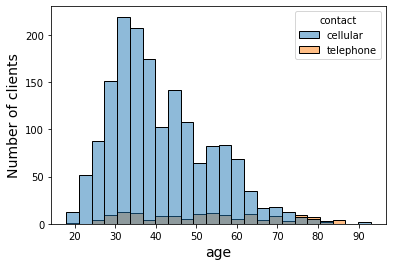

In [9]:
plt.rcParams["axes.labelsize"] = 14
sns.histplot(data=df, x=df['age'], hue='contact', bins='auto')
plt.ylabel('Number of clients')
plt.show()

Also, *contact* by itself didn't seem correlated with *subscribed*:

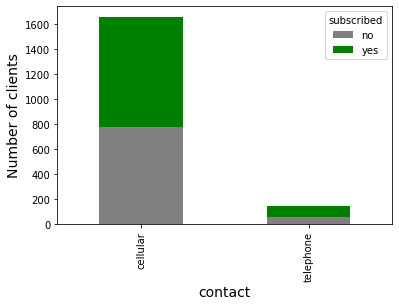

In [10]:
plt.rcParams["axes.labelsize"] = 14
crosstab_CL = pd.crosstab(df['contact'], df['subscribed'])
crosstab_CL.plot(kind='bar', stacked=True, color=['grey', 'green'])
plt.ylabel('Number of clients')
plt.show()

For these reasons, *contact* will just be inferred based on the client's age.

In [11]:
df['contact'] = df['contact'].fillna(df.groupby('age')['contact'].transform(lambda x:x.mode().iat[0]))

## Discretisation of *pdays*

In [12]:
df.isna().sum()

age            12
job             5
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

This attribute has a very large number of entries with a value of -1, representing the client not being called in the previous campaign. &ensp; This is a true NA and so it is given its own category within *pdays*, along with a handful of other day ranges.

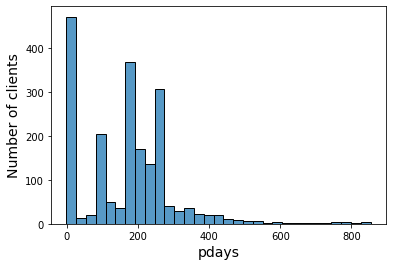

In [13]:
sns.histplot(data=df, x=df['pdays'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('pdays')
plt.ylabel('Number of clients')
plt.show()

In [14]:
bins=[-2, 0, 100, 200, 300, 400, 600, 800, 1000]
labels=['No Call', '0-100', '101-200', '201-300', '301-400', '401-600', '601-800', '800+']

df['pdays'] = pd.cut(df['pdays'], bins, labels=labels)

df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign    pdays  previous poutcome  \
1995   cellular   16   sep       327         2  No Call         0      NaN   
1996   cellular   16   sep      1334         2  No Call         0      NaN   
1997  telephone   17   sep       231         1  No Call         0      NaN   
1998   cellular   20   sep       185         1  No Call         0      NaN   
1999   cellular   22   sep       208         2  No Call         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

## Normalising 'month' column

Months are interesting. &ensp; They have an order, but not in the same way as education does. &ensp; They are given a cyclical encoding, represented by sine and cosine transformations after numeric encoding of the month values. &ensp; These new features capture the yearly cycle.

In [15]:
# month_encoding = {
#     'nov': 1, 'dec': 1, 'jan': 1, # winter months given value of 1
#     'feb': 2, 'mar': 2, 'apr': 2, # spring months given value of 2
#     'may': 3, 'jun': 3, 'jul': 3, # autumn months given value of 3
#     'aug': 2, 'sep': 2, 'oct': 2  # summer months given value of 2
# }

# df['month'] = df['month'].replace(month_encoding)
# df.rename(columns = {'month':'season'}, inplace = True)

# df.head()

In [16]:
month_encoding = {
    'jan':  1, 'feb':  2, 'mar':  3,
    'apr':  4, 'may':  5, 'jun':  6,
    'jul':  7, 'aug':  8, 'sep':  9,
    'oct': 10, 'nov': 11, 'dec':  12 
}

df['month'] = df['month'].replace(month_encoding)

In [17]:
month_norm = 2 * np.pi * df['month'] / df['month'].max() # normalise months to 0..2pi range

df['cos_month'] = np.cos(month_norm)
df['sin_month'] = np.sin(month_norm)
df.drop(columns=['month'], inplace=True)

day_norm = 2 * np.pi * df['day'] / df['day'].max()

df['cos_day'] = np.cos(day_norm)
df['sin_day'] = np.sin(day_norm)
df.drop(columns=['day'], inplace=True)

df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  duration  campaign    pdays  previous poutcome subscribed  \
1995   cellular       327         2  No Call         0      NaN        yes   
1996   cellular      1334         2  No Call         0      NaN        yes   
1997  telephone       231         1  No Call         0      NaN        yes   
1998   cellular       185         1  No Call         0      NaN        yes   
1999   cellular       208         2  No Call         0      NaN        yes   

         cos_month  sin_month   cos_day   sin_day  
1995 -1.836970e-16       -1.0 -0.994869 -0.101168  
1996 -1.836970e-16       -1.0 -0.994869 -0.101168  
1997 -1.836970e-16       -1.0 -0.954139 -0.299363  
1998 -1.836970e-16       -1.0 -0.612106 -0.790776  
1999 -1.836970e-16       -1.0 -0.250653 -0.968077

## Transforming *balance* and *duration*

Two features, *balance* and *duration* use units which give them large magnitudes, and also are quite skewed. &ensp; These are merely log transformed to scale the features and to take the soften the skew a bit.

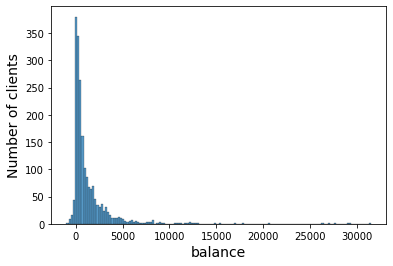

In [18]:
sns.histplot(data=df, x=df['balance'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('balance')
plt.ylabel('Number of clients')
plt.show()

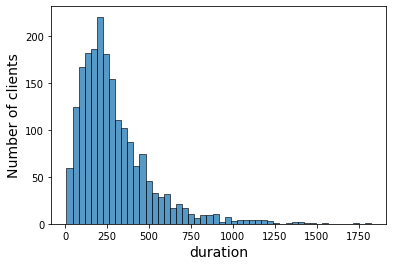

In [19]:
sns.histplot(data=df, x=df['duration'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('duration')
plt.ylabel('Number of clients')
plt.show()

In [20]:
df[['balance', 'duration']].min()

balance    -980
duration      7
dtype: int64

In [21]:
df['balance'] = np.log(df['balance'] + -df['balance'].min() + 1)
df['duration'] = np.log(df['duration'])

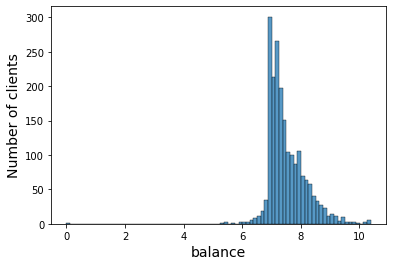

In [22]:
sns.histplot(data=df, x=df['balance'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('balance')
plt.ylabel('Number of clients')
plt.show()

This didn't solve the issue entirely here, but it'll do.

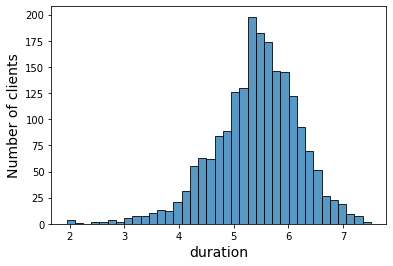

In [23]:
sns.histplot(data=df, x=df['duration'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('duration')
plt.ylabel('Number of clients')
plt.show()

In [24]:
# df.dropna(['job'], inplace=True)
# df[df['job'].notna()]
# df.dropna(subset=['job'], inplace=True)
df.isna().sum()

age            12
job             5
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact         0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
cos_month       0
sin_month       0
cos_day         0
sin_day         0
dtype: int64

## Transforming *campaign* and *previous*

*campaign* and *previous* both have exponential distrbutions:

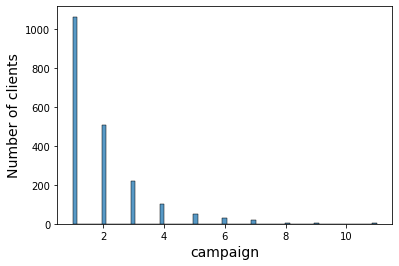

In [25]:
sns.histplot(data=df, x=df['campaign'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('campaign')
plt.ylabel('Number of clients')
plt.show()

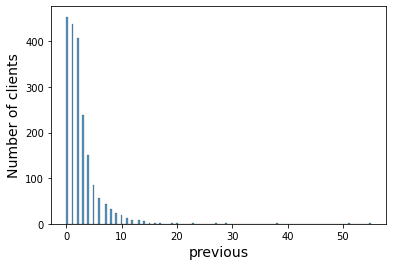

In [26]:
sns.histplot(data=df, x=df['previous'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('previous')
plt.ylabel('Number of clients')
plt.show()

These are both now transformed to normal distrbutions.

In [27]:
df[['campaign', 'previous']].min()

campaign    1
previous    0
dtype: int64

In [28]:
# df['campaign'] = np.log(df['campaign'])
# df['previous'] = np.log(df['previous'] + 1)

campaign_list = df['campaign'].to_numpy()
previous_list = df['previous'].to_numpy()

qt = QuantileTransformer(output_distribution='normal')

df['campaign'] = qt.fit_transform(campaign_list.reshape(-1, 1))
df['previous'] = qt.fit_transform(previous_list.reshape(-1, 1))

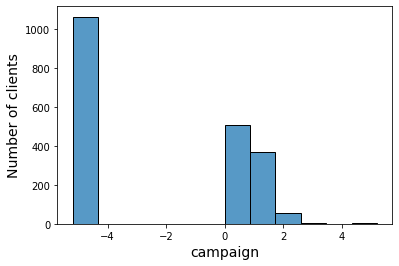

In [29]:
sns.histplot(data=df, x=df['campaign'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('campaign')
plt.ylabel('Number of clients')
plt.show()

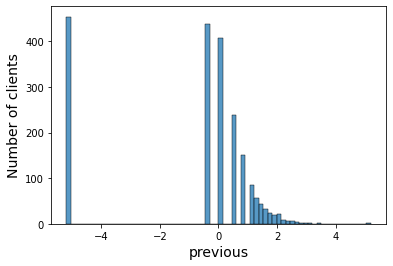

In [30]:
sns.histplot(data=df, x=df['previous'], bins='auto')
plt.rcParams["axes.labelsize"] = 14
plt.xlabel('previous')
plt.ylabel('Number of clients')
plt.show()

These both ended up bi-modal. &ensp;  Not ideal, but at least they're scaled!

## Encoding education in an ordinal manner

Education level has a natural ordering to it and so *education* is encoded in a way that emphasises this ordering, while having the added benefit of being converted to a numeric type.

In [31]:
print(df.education.unique())

['tertiary' 'secondary' nan 'primary']


In [32]:
education_encoding = {
    'primary':   1,
    'secondary': 2,
    'tertiary':  3
}

df['education'] = df['education'].replace(education_encoding)

In [33]:
df.tail()

age           job  marital  education default   balance housing loan  \
1995  20.0       student   single        NaN      no  8.233769      no   no   
1996  28.0        admin.   single        2.0      no  7.010312      no   no   
1997  81.0       retired  married        1.0      no  7.666222      no   no   
1998  46.0      services  married        1.0      no  8.579980     yes   no   
1999  40.0  entrepreneur  married        2.0      no  8.907071      no   no   

        contact  duration  campaign    pdays  previous poutcome subscribed  \
1995   cellular  5.789960  0.406079  No Call -5.199338      NaN        yes   
1996   cellular  7.195937  0.406079  No Call -5.199338      NaN        yes   
1997  telephone  5.442418 -5.199338  No Call -5.199338      NaN        yes   
1998   cellular  5.220356 -5.199338  No Call -5.199338      NaN        yes   
1999   cellular  5.337538  0.406079  No Call -5.199338      NaN        yes   

         cos_month  sin_month   cos_day   sin_day  
1995 -1.836970e-16       -1.0 -0.994869 -0.101168  
1996 -1.836970e-16       -1.0 -0.994869 -0.101168  
1997 -1.836970e-16       -1.0 -0.954139 -0.299363  
1998 -1.836970e-16       -1.0 -0.612106 -0.790776  
1999 -1.836970e-16       -1.0 -0.250653 -0.968077

In [34]:
df.dtypes

age            float64
job             object
marital         object
education      float64
default         object
balance        float64
housing         object
loan            object
contact         object
duration       float64
campaign       float64
pdays         category
previous       float64
poutcome        object
subscribed      object
cos_month      float64
sin_month      float64
cos_day        float64
sin_day        float64
dtype: object

## Dealing with *poutcome*

*poutcome* has a lot of missing values, but they present the client not being contacted during the previous campaign. &ensp; It makes sense to one-hot this attribute. &ensp; *pdays* is also encoded here. &ensp; *job* is one-hot encoded while ignoring the five remaining with missing values.

In [35]:
print(df.poutcome.unique())

['failure' 'other' 'success' nan]


In [36]:
df = pd.get_dummies(df, columns=['poutcome'],
                        dummy_na=True, 
                        drop_first=True)

df = pd.get_dummies(df, columns=['job', 'pdays'],
                        dummy_na=False, 
                        drop_first=True)
pd.set_option('display.max_columns', None)

df.tail()

age  marital  education default   balance housing loan    contact  \
1995  20.0   single        NaN      no  8.233769      no   no   cellular   
1996  28.0   single        2.0      no  7.010312      no   no   cellular   
1997  81.0  married        1.0      no  7.666222      no   no  telephone   
1998  46.0  married        1.0      no  8.579980     yes   no   cellular   
1999  40.0  married        2.0      no  8.907071      no   no   cellular   

      duration  campaign  previous subscribed     cos_month  sin_month  \
1995  5.789960  0.406079 -5.199338        yes -1.836970e-16       -1.0   
1996  7.195937  0.406079 -5.199338        yes -1.836970e-16       -1.0   
1997  5.442418 -5.199338 -5.199338        yes -1.836970e-16       -1.0   
1998  5.220356 -5.199338 -5.199338        yes -1.836970e-16       -1.0   
1999  5.337538  0.406079 -5.199338        yes -1.836970e-16       -1.0   

       cos_day   sin_day  poutcome_other  poutcome_success  poutcome_nan  \
1995 -0.994869 -0.101168               0                 0             1   
1996 -0.994869 -0.101168               0                 0             1   
1997 -0.954139 -0.299363               0                 0             1   
1998 -0.612106 -0.790776               0                 0             1   
1999 -0.250653 -0.968077               0                 0             1   

      job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
1995                0                 0              0               0   
1996                0                 0              0               0   
1997                0                 0              0               0   
1998                0                 0              0               0   
1999                0                 1              0               0   

      job_retired  job_self-employed  job_services  job_student  \
1995            0                  0             0            1   
1996            0                  0             0            0   
1997            1                  0             0            0   
1998            0                  0             1            0   
1999            0                  0             0            0   

      job_technician  job_unemployed  pdays_0-100  pdays_101-200  \
1995               0               0            0              0   
1996               0               0            0              0   
1997               0               0            0              0   
1998               0               0            0              0   
1999               0               0            0              0   

      pdays_201-300  pdays_301-400  pdays_401-600  pdays_601-800  pdays_800+  
1995              0              0              0              0           0  
1996              0              0              0              0           0  
1997              0              0              0              0           0  
1998              0              0              0              0           0  
1999              0              0              0              0           0

## One-hotting the rest

All remaining categoricals are now one-hotted, including the inferred *contact*.

In [37]:
df = pd.get_dummies(df, columns=['subscribed', 'marital', 'default',
                                 'loan', 'housing', 'contact',],
                    drop_first=True)
df.tail()

age  education   balance  duration  campaign  previous     cos_month  \
1995  20.0        NaN  8.233769  5.789960  0.406079 -5.199338 -1.836970e-16   
1996  28.0        2.0  7.010312  7.195937  0.406079 -5.199338 -1.836970e-16   
1997  81.0        1.0  7.666222  5.442418 -5.199338 -5.199338 -1.836970e-16   
1998  46.0        1.0  8.579980  5.220356 -5.199338 -5.199338 -1.836970e-16   
1999  40.0        2.0  8.907071  5.337538  0.406079 -5.199338 -1.836970e-16   

      sin_month   cos_day   sin_day  poutcome_other  poutcome_success  \
1995       -1.0 -0.994869 -0.101168               0                 0   
1996       -1.0 -0.994869 -0.101168               0                 0   
1997       -1.0 -0.954139 -0.299363               0                 0   
1998       -1.0 -0.612106 -0.790776               0                 0   
1999       -1.0 -0.250653 -0.968077               0                 0   

      poutcome_nan  job_blue-collar  job_entrepreneur  job_housemaid  \
1995             1                0                 0              0   
1996             1                0                 0              0   
1997             1                0                 0              0   
1998             1                0                 0              0   
1999             1                0                 1              0   

      job_management  job_retired  job_self-employed  job_services  \
1995               0            0                  0             0   
1996               0            0                  0             0   
1997               0            1                  0             0   
1998               0            0                  0             1   
1999               0            0                  0             0   

      job_student  job_technician  job_unemployed  pdays_0-100  pdays_101-200  \
1995            1               0               0            0              0   
1996            0               0               0            0              0   
1997            0               0               0            0              0   
1998            0               0               0            0              0   
1999            0               0               0            0              0   

      pdays_201-300  pdays_301-400  pdays_401-600  pdays_601-800  pdays_800+  \
1995              0              0              0              0           0   
1996              0              0              0              0           0   
1997              0              0              0              0           0   
1998              0              0              0              0           0   
1999              0              0              0              0           0   

      subscribed_yes  marital_married  marital_single  default_yes  loan_yes  \
1995               1                0               1            0         0   
1996               1                0               1            0         0   
1997               1                1               0            0         0   
1998               1                1               0            0         0   
1999               1                1               0            0         0   

      housing_yes  contact_telephone  
1995            0                  0  
1996            0                  0  
1997            0                  1  
1998            1                  0  
1999            0                  0

In [38]:
df.isna().sum()

age                   12
education            104
balance                0
duration               0
campaign               0
previous               0
cos_month              0
sin_month              0
cos_day                0
sin_day                0
poutcome_other         0
poutcome_success       0
poutcome_nan           0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
pdays_0-100            0
pdays_101-200          0
pdays_201-300          0
pdays_301-400          0
pdays_401-600          0
pdays_601-800          0
pdays_800+             0
subscribed_yes         0
marital_married        0
marital_single         0
default_yes            0
loan_yes               0
housing_yes            0
contact_telephone      0
dtype: int64

## Imputing *age* and *education* using KNN

There are a quite a few missing *education* entries and a handful missing *age* entries. &ensp; I decided to use a nearest neighbours function to fill these in.

In [39]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

## Converting *age* to a category.

Leaving *age* as a numeric type may be a reasonable thing to do here and I can't say for sure at this stage if it's the best thing to do, but I've edged towards creating age groups instead. &ensp; Doing this at the end, after using the KNN function worked best. &ensp; The age categories are then one-hot encoded so that everything in the dataset is numeric.

In [40]:
bins=[0, 25, 35, 45, 55, 65, 100]
labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+']

In [41]:
df['age'] = pd.cut(df['age'], bins, labels=labels)

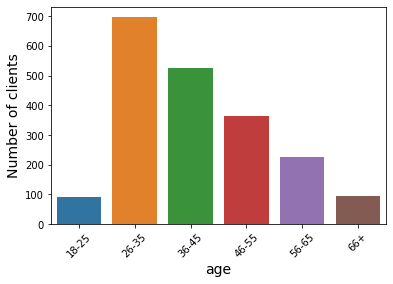

In [42]:
sns.countplot(x='age', data=df)
plt.xticks(rotation = 45)
plt.xlabel('age')
plt.ylabel('Number of clients')
plt.show()

In [43]:
df = pd.get_dummies(df, columns=['age'], drop_first=True)

In [44]:
df.isna().sum()

education            0
balance              0
duration             0
campaign             0
previous             0
cos_month            0
sin_month            0
cos_day              0
sin_day              0
poutcome_other       0
poutcome_success     0
poutcome_nan         0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
pdays_0-100          0
pdays_101-200        0
pdays_201-300        0
pdays_301-400        0
pdays_401-600        0
pdays_601-800        0
pdays_800+           0
subscribed_yes       0
marital_married      0
marital_single       0
default_yes          0
loan_yes             0
housing_yes          0
contact_telephone    0
age_26-35            0
age_36-45            0
age_46-55            0
age_56-65            0
age_66+              0
dtype: int64

In [45]:
df.tail()

education   balance  duration  campaign  previous     cos_month  \
1994        2.2  8.233769  5.789960  0.406079 -5.199338 -1.836970e-16   
1995        2.0  7.010312  7.195937  0.406079 -5.199338 -1.836970e-16   
1996        1.0  7.666222  5.442418 -5.199338 -5.199338 -1.836970e-16   
1997        1.0  8.579980  5.220356 -5.199338 -5.199338 -1.836970e-16   
1998        2.0  8.907071  5.337538  0.406079 -5.199338 -1.836970e-16   

      sin_month   cos_day   sin_day  poutcome_other  poutcome_success  \
1994       -1.0 -0.994869 -0.101168             0.0               0.0   
1995       -1.0 -0.994869 -0.101168             0.0               0.0   
1996       -1.0 -0.954139 -0.299363             0.0               0.0   
1997       -1.0 -0.612106 -0.790776             0.0               0.0   
1998       -1.0 -0.250653 -0.968077             0.0               0.0   

      poutcome_nan  job_blue-collar  job_entrepreneur  job_housemaid  \
1994           1.0              0.0               0.0            0.0   
1995           1.0              0.0               0.0            0.0   
1996           1.0              0.0               0.0            0.0   
1997           1.0              0.0               0.0            0.0   
1998           1.0              0.0               1.0            0.0   

      job_management  job_retired  job_self-employed  job_services  \
1994             0.0          0.0                0.0           0.0   
1995             0.0          0.0                0.0           0.0   
1996             0.0          1.0                0.0           0.0   
1997             0.0          0.0                0.0           1.0   
1998             0.0          0.0                0.0           0.0   

      job_student  job_technician  job_unemployed  pdays_0-100  pdays_101-200  \
1994          1.0             0.0             0.0          0.0            0.0   
1995          0.0             0.0             0.0          0.0            0.0   
1996          0.0             0.0             0.0          0.0            0.0   
1997          0.0             0.0             0.0          0.0            0.0   
1998          0.0             0.0             0.0          0.0            0.0   

      pdays_201-300  pdays_301-400  pdays_401-600  pdays_601-800  pdays_800+  \
1994            0.0            0.0            0.0            0.0         0.0   
1995            0.0            0.0            0.0            0.0         0.0   
1996            0.0            0.0            0.0            0.0         0.0   
1997            0.0            0.0            0.0            0.0         0.0   
1998            0.0            0.0            0.0            0.0         0.0   

      subscribed_yes  marital_married  marital_single  default_yes  loan_yes  \
1994             1.0              0.0             1.0          0.0       0.0   
1995             1.0              0.0             1.0          0.0       0.0   
1996             1.0              1.0             0.0          0.0       0.0   
1997             1.0              1.0             0.0          0.0       0.0   
1998             1.0              1.0             0.0          0.0       0.0   

      housing_yes  contact_telephone  age_26-35  age_36-45  age_46-55  \
1994          0.0                0.0          0          0          0   
1995          0.0                0.0          1          0          0   
1996          0.0                1.0          0          0          0   
1997          1.0                0.0          0          0          1   
1998          0.0                0.0          0          1          0   

      age_56-65  age_66+  
1994          0        0  
1995          0        0  
1996          0        1  
1997          0        0  
1998          0        0

---

## Summary of how each feature was handled

**age**

While *age* does represent a completely continuous quantity, there are underlying factors that are common across a lot of people of similar age ranges. &ensp; Being young, middle aged, or elderly comes with different levels of maturity, health, and countless other difficult to measure underlying factors that are broadly common across people.

For this reason, I feel changing *age* to a categorical attribute is a good idea here, as the theme of this dataset (a client's likelyhood of making a financial investment) may very well be infuenced by one of these underlying factors. &ensp; I am also not considering these new age groupings to be representing an ordinal category. &ensp;  They are ordinal to some degree, but there are underlying factors that do not increase or decrease monotonically.   &ensp; As a result, these age groupings are eventually one-hot encoded.

**job**

There are only ten clients without the *job* attribute filled in. &ensp; Because it this, job is first inferred from *education*, but because five of these clients also had no education listed, the remaining five are later ignored while one-hot encoding *job*. 

**marital**

*marital* is simply one-hot encoded.

**education**

*education* has a natural ordinal encoding, so this was the choice I made here. &ensp; As there were quite a number of missing *education* values though, I chose to impute the missing values using a KNN algorithm.

**default** 

*default* is simply one-hot encoded.

**balance**

*balance* is a continuous numeric attribute and so it is just given a log transformation to scale it. &ensp; I had considered making categories for it, but it didn't split as naturally as *age* did. &ensp; I chose to remove one extreme outlier, as it was twice as far from the mean as the next biggest outliers and seemed to represent a completely unique client.

**housing**

*housing* is simply one-hot encoded.

**loan**

*loan* is simply one-hot encoded.

**contact**

The *contact* attribute was missing a surprising number of entries, but it doesn't feel like a true NA, as the client had to be contacted somehow. &ensp; Contact was inferred from *age*, which looked to correlate reasonably well with it. &ensp; It is worth noting that *contact* doesn't look to matter much anyway.

**day**

*day* was transformed to a pair of cyclical variables, as there is a natural cyclical flow to it. &ensp; I think there might be some merit to categorising the day as different sections of the month (*start*, *middle*, and *end* for example), but I think the cyclical encoding captures this to some degree anyway. 

**month**

*month* was given a cyclical encoding similar to *day*, and this encoding is tailor-made for *month* even more so than *day*, due to the natural eb and flow of the yearly cycle. &ensp; I had initially considered encoding the attribute as seasons, but realised I was adding bias as I don't have an intuitive feel for the seasons in Portugal!

**duration**

*duration*, like *balance*, is a continuous attribute and so it was merely given a log transformation to scale its values.

**campaign**

*campaign* is just a simple discrete numeric type, but with an exponential distribution. &ensp; It was converted to a normal distribution, but it then had bi-modal behaviour.

**pdays**

*pdays* was certainly the dark horse in this dataset. &ensp; There was a a huge number of entries with a *pdays* value of -1, representing the fact the client had not been previously contacted. &ensp; These were true NA values and no numeric replacement of the -1 value would make sense and capture the behaviour here. &ensp; I felt the best choice here was to group *pdays* into categories as was done with *age*, which made intuitive sense as its a measure of a time period (*recently*, *a few months ago*, *over a year ago*, etc). &ensp; This approach then had the added bonus of allowing a separate category to represent the client not being contacted before (though this just amounts to a 0 for each other category)

**previous**

*previous* is just a simple discrete numeric type, but with an exponential distribution like *campaign*. &ensp; It was converted to a normal distribution, but it then had bi-modal behaviour.

**poutcome**

*poutcome* had quite a number of true NA values, implying the client was not contacted during the previous campaign. &ensp; A one-hot encoding was a natural fit here as all the NA values seemed to have the same underlying cause, and so the correct behaviour is retained in the dataset.